In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4 as nc
import cmocean.cm as cm
import os
from datetime import datetime, timedelta


In [2]:
BASE_PATHS = {
    "Baseline": "/ocean/atall/MOAD/Model/202410b/oxygen_forZ2018/",
    "WWTP_freshw": "/ocean/atall/MOAD/Model/202410b/wastewatero2_freshwater", 
    "WWTP_withNut": "/ocean/atall/MOAD/Model/202410b/wastewatero2"
}

PUGET_SOUND_REGION = {
    'name': 'Puget Sound',
    'jj1': 0,  
    'jj2': 230,
    'ii1': 70, 
    'ii2': 325 
}

def get_full_domain_region(depth_data):
    """Get the full model domain region"""
    ny, nx = depth_data.shape[2], depth_data.shape[3]
    return {
        'name': 'Entire System',
        'jj1': 0,
        'jj2': ny,
        'ii1': 0,
        'ii2': nx
    }

with xr.open_dataset('/ocean/atall/MOAD/grid/mesh_mask_202310b.nc') as mesh:
    depth = mesh.gdept_0.values
    e3t = mesh.e3t_0.values  
    mbathy = mesh.mbathy.values 

ENTIRE_SYSTEM_REGION = get_full_domain_region(depth)

wwtp_positions = "/ocean/atall/MOAD/Obs/PugetSound/WWTP/wastewater_20251118.nc"
src = xr.open_dataset(wwtp_positions)
flux_nonzero = src["flux"].max(dim="time_counter") > 0
source_indices = np.argwhere(flux_nonzero.values)
all_y, all_x = zip(*source_indices)
all_y = np.array(all_y)
all_x = np.array(all_x)

mbathy_data = mbathy
depth_data = depth
mbathy_vals = mbathy_data[0, all_y, all_x] - 1
valid_indices = mbathy_vals.astype(int)
wwtp_discharge_depths = depth_data[0, valid_indices, all_y, all_x]


In [3]:
# Load WWTP positions and categorize by discharge depth
wwtp_positions = "/ocean/atall/MOAD/Obs/PugetSound/WWTP/wastewater_20251118.nc"
src = xr.open_dataset(wwtp_positions)
flux_nonzero = src["flux"].max(dim="time_counter") > 0
source_indices = np.argwhere(flux_nonzero.values)
all_y, all_x = zip(*source_indices)
all_y = np.array(all_y)
all_x = np.array(all_x)

mbathy_data = mbathy
depth_data = depth
mbathy_vals = mbathy_data[0, all_y, all_x] - 1
valid_indices = mbathy_vals.astype(int)
wwtp_discharge_depths = depth_data[0, valid_indices, all_y, all_x]

#depth_ranges = [0.5, 10, 20, 50, 200]
#depth_labels = ['0-10m', '10-20m', '20-50m', '50-200m']
#colors = ['blue', 'green', 'orange', 'red']
depth_ranges = [0.5, 200]
depth_labels = ['WWTPs']
colors = ['red']

depth_categories = np.digitize(wwtp_discharge_depths, depth_ranges) - 1
depth_categories = np.clip(depth_categories, 0, len(depth_ranges)-2)

# Create groups for each discharge depth category
category_groups = {}
for i, label in enumerate(depth_labels):
    mask = depth_categories == i
    if np.any(mask):
        category_groups[label] = {
            'indices': np.where(mask)[0],
            'y': all_y[mask],
            'x': all_x[mask],
            'discharge_depths': wwtp_discharge_depths[mask],
            'color': colors[i],
            'n_wwtps': np.sum(mask)
        }
    else:
        category_groups[label] = None



### WWTP Sources, Puget Sound and Salish Sea WWTPs impact

In [4]:
def get_daily_files(base_path, start_date, end_date):
    """Get list of daily files for a given period"""
    files = []
    current_date = start_date
    
    while current_date <= end_date:
        day_str = f"{current_date.day:02d}"
        month_str = current_date.strftime("%b").lower()
        year_str = str(current_date.year)[-2:]
        dir_name = f"{day_str}{month_str}{year_str}"
        dir_path = os.path.join(base_path, dir_name)
        
        if os.path.exists(dir_path):
            date_str = current_date.strftime("%Y%m%d")
            chem_file = f"SalishSea_1d_{date_str}_{date_str}_chem_T.nc"
            biol_file = f"SalishSea_1d_{date_str}_{date_str}_biol_T.nc"
            
            chem_path = os.path.join(dir_path, chem_file)
            biol_path = os.path.join(dir_path, biol_file)
            
            if os.path.exists(chem_path) and os.path.exists(biol_path):
                files.append((current_date, chem_path, biol_path))
        
        current_date += timedelta(days=1)
    
    return files

In [5]:
def integrate_region(ds_chem, ds_biol, region, mbathy_data, depth_data, e3t):
    """Integrate variables over a specified region"""
    
    # Extract region bounds
    jj1, jj2 = region['jj1'], region['jj2']
    ii1, ii2 = region['ii1'], region['ii2']
    
    # Initialize results
    results = {
        'nitrate': 0,
        'ammonium': 0,
        'diatoms': 0,
        'flagellates': 0,
        'PON': 0,
        'DON': 0,
        'oxygen_upper': 0,  # 0-50m
        'oxygen_lower': 0,  # >50m
        'area_cells': (jj2 - jj1) * (ii2 - ii1),
        'wet_cells': 0,
        'total_volume': 0
    }
    
    for j in range(jj1, jj2):
        for i in range(ii1, ii2):
            n_levels = int(mbathy_data[0, j, i])
            if n_levels == 0:
                continue
            
            results['wet_cells'] += 1
            
            depth_slice = depth_data[0, :n_levels, j, i]
            e3t_slice = e3t[0, :n_levels, j, i]
            
            cell_volume = np.sum(e3t_slice)
            results['total_volume'] += cell_volume
            
            # NITRATE - integrate whole water column
            if 'nitrate' in ds_biol.variables:
                nitrate_profile = ds_biol.nitrate.values[0, :n_levels, j, i]
                results['nitrate'] += np.sum(nitrate_profile * e3t_slice)
            
            # AMMONIUM - integrate whole water column
            if 'ammonium' in ds_biol.variables:
                ammonium_profile = ds_biol.ammonium.values[0, :n_levels, j, i]
                results['ammonium'] += np.sum(ammonium_profile * e3t_slice)
            
            # DIATOMS - integrate whole water column
            if 'diatoms' in ds_biol.variables:
                diatoms_profile = ds_biol.diatoms.values[0, :n_levels, j, i]
                results['diatoms'] += np.sum(diatoms_profile * e3t_slice)
            
            # FLAGELLATES - integrate whole water column
            if 'flagellates' in ds_biol.variables:
                flagellates_profile = ds_biol.flagellates.values[0, :n_levels, j, i]
                results['flagellates'] += np.sum(flagellates_profile * e3t_slice)
    
            # PON - integrate whole water column
            if 'particulate_organic_nitrogen' in ds_biol.variables:
                pon_profile = ds_biol.particulate_organic_nitrogen.values[0, :n_levels, j, i]
                results['PON'] += np.sum(pon_profile * e3t_slice)
            
            # DON - integrate whole water column
            if 'dissolved_organic_nitrogen' in ds_biol.variables:
                don_profile = ds_biol.dissolved_organic_nitrogen.values[0, :n_levels, j, i]
                results['DON'] += np.sum(don_profile * e3t_slice)
    
            # DISSOLVED OXYGEN - separate integration for 0-50m and >50m
            if 'dissolved_oxygen' in ds_chem.variables:
                oxygen_profile = ds_chem.dissolved_oxygen.values[0, :n_levels, j, i]
                
                # Create masks for depth layers
                mask_upper = depth_slice <= 50
                mask_lower = depth_slice > 50
                
                results['oxygen_upper'] += np.sum(oxygen_profile[mask_upper] * e3t_slice[mask_upper])
                results['oxygen_lower'] += np.sum(oxygen_profile[mask_lower] * e3t_slice[mask_lower])
            
    return results

In [6]:
def integrate_at_wwtp_locations(ds_chem, ds_biol, category_groups, mbathy_data, depth_data, e3t):
    """Integrate variables at WWTP locations, grouped by discharge depth"""
    
    results = {}
    
    for label, group in category_groups.items():
        if group is None or group['n_wwtps'] == 0:
            results[label] = None
            continue
        
        # Initialize sums for this depth category
        nitrate_sum = 0
        ammonium_sum = 0
        diatoms_sum = 0
        flagellates_sum = 0
        pon_sum = 0
        don_sum = 0
        oxygen_upper_sum = 0  # 0-50m
        oxygen_lower_sum = 0  # >50m
        
        # Process each WWTP in this depth category
        for i in range(group['n_wwtps']):
            y = group['y'][i]
            x = group['x'][i]
            
            n_levels = int(mbathy_data[0, y, x])
            if n_levels == 0:
                continue
            
            depth_slice = depth_data[0, :n_levels, y, x]
            e3t_slice = e3t[0, :n_levels, y, x]
            
            # NITRATE - integrate whole water column
            if 'nitrate' in ds_biol.variables:
                nitrate_profile = ds_biol.nitrate.values[0, :n_levels, y, x]
                nitrate_integrated = np.sum(nitrate_profile * e3t_slice)
                nitrate_sum += nitrate_integrated
            
            # AMMONIUM - integrate whole water column
            if 'ammonium' in ds_biol.variables:
                ammonium_profile = ds_biol.ammonium.values[0, :n_levels, y, x]
                ammonium_integrated = np.sum(ammonium_profile * e3t_slice)
                ammonium_sum += ammonium_integrated
            
            # DIATOMS - integrate whole water column
            if 'diatoms' in ds_biol.variables:
                diatoms_profile = ds_biol.diatoms.values[0, :n_levels, y, x]
                diatoms_integrated = np.sum(diatoms_profile * e3t_slice)
                diatoms_sum += diatoms_integrated
            
            # FLAGELLATES - integrate whole water column
            if 'flagellates' in ds_biol.variables:
                flagellates_profile = ds_biol.flagellates.values[0, :n_levels, y, x]
                flagellates_integrated = np.sum(flagellates_profile * e3t_slice)
                flagellates_sum += flagellates_integrated
        
            # PON - integrate whole water column
            if 'particulate_organic_nitrogen' in ds_biol.variables:
                pon_profile = ds_biol.particulate_organic_nitrogen.values[0, :n_levels, y, x]
                pon_integrated = np.sum(pon_profile * e3t_slice)
                pon_sum += pon_integrated
            
            # DON - integrate whole water column
            if 'dissolved_organic_nitrogen' in ds_biol.variables:
                don_profile = ds_biol.dissolved_organic_nitrogen.values[0, :n_levels, y, x]
                don_integrated = np.sum(don_profile * e3t_slice)
                don_sum += don_integrated
        
            # DISSOLVED OXYGEN - separate integration for 0-50m and >50m
            if 'dissolved_oxygen' in ds_chem.variables:
                oxygen_profile = ds_chem.dissolved_oxygen.values[0, :n_levels, y, x]
                
                # Create masks for depth layers
                mask_upper = depth_slice <= 50
                mask_lower = depth_slice > 50
                
                oxygen_upper = np.sum(oxygen_profile[mask_upper] * e3t_slice[mask_upper])
                oxygen_lower = np.sum(oxygen_profile[mask_lower] * e3t_slice[mask_lower])
                
                oxygen_upper_sum += oxygen_upper
                oxygen_lower_sum += oxygen_lower
            
        # Store results for this depth category
        results[label] = {
            'nitrate': nitrate_sum,
            'ammonium': ammonium_sum,
            'diatoms': diatoms_sum,
            'flagellates': flagellates_sum,
            'PON': pon_sum,
            'DON': don_sum,
            'oxygen_upper': oxygen_upper_sum,
            'oxygen_lower': oxygen_lower_sum,
            'n_wwtps': group['n_wwtps'],
            'avg_discharge_depth': np.mean(group['discharge_depths']) if len(group['discharge_depths']) > 0 else 0
        }
    
    return results

In [10]:
def process_simulation(sim_name, base_path, start_date, end_date, category_groups):
    """Process simulation results for WWTP points, Puget Sound region, and entire system"""
    
    print(f"\nProcessing {sim_name}...")
    daily_files = get_daily_files(base_path, start_date, end_date)
    
    if not daily_files:
        print(f"No files found for {sim_name}")
        return None
    
    # Initialize results structure
    results = {
        'time': [],
        'wwtp_categories': {},
        'regions': {
            'Puget Sound': {
                'nitrate': [],
                'ammonium': [],
                'diatoms': [],
                'flagellates': [],
                'PON': [],
                'DON': [],
                'oxygen_upper': [],
                'oxygen_lower': [],
                'wet_cells': 0,
                'total_volume': 0
            },
            'Entire System': {
                'nitrate': [],
                'ammonium': [],
                'diatoms': [],
                'flagellates': [],
                'PON': [],
                'DON': [],
                'oxygen_upper': [],
                'oxygen_lower': [],
                'wet_cells': 0,
                'total_volume': 0
            }
        }
    }
    
    for label in depth_labels:
        if category_groups[label] is not None:
            results['wwtp_categories'][label] = {
                'nitrate': [],
                'ammonium': [],
                'diatoms': [],
                'flagellates': [],
                'PON': [],
                'DON': [],
                'oxygen_upper': [],
                'oxygen_lower': []
            }
    
    # Process each day
    for date, chem_path, biol_path in daily_files:
        try:
            ds_chem = xr.open_dataset(chem_path)
            ds_biol = xr.open_dataset(biol_path)
            
            time_val = ds_chem.time_counter.values[0]
            results['time'].append(time_val)
            
            # Integrate at WWTP locations
            wwtp_results = integrate_at_wwtp_locations(
                ds_chem, ds_biol, category_groups, 
                mbathy_data, depth_data, e3t
            )
            
            for label in depth_labels:
                if label in wwtp_results and wwtp_results[label] is not None:
                    cat_results = wwtp_results[label]
                    results['wwtp_categories'][label]['nitrate'].append(cat_results['nitrate'])
                    results['wwtp_categories'][label]['ammonium'].append(cat_results['ammonium'])
                    results['wwtp_categories'][label]['diatoms'].append(cat_results['diatoms'])
                    results['wwtp_categories'][label]['flagellates'].append(cat_results['flagellates'])
                    results['wwtp_categories'][label]['PON'].append(cat_results['PON'])
                    results['wwtp_categories'][label]['DON'].append(cat_results['DON'])
                    results['wwtp_categories'][label]['oxygen_upper'].append(cat_results['oxygen_upper'])
                    results['wwtp_categories'][label]['oxygen_lower'].append(cat_results['oxygen_lower'])
            
            # Integrate over Puget Sound
            puget_results = integrate_region(
                ds_chem, ds_biol, PUGET_SOUND_REGION,
                mbathy_data, depth_data, e3t
            )
            
            for var in ['nitrate', 'ammonium', 'diatoms', 'flagellates', 'PON', 'DON', 'oxygen_upper', 'oxygen_lower']:
                results['regions']['Puget Sound'][var].append(puget_results[var])
            
            if len(results['time']) == 1:
                results['regions']['Puget Sound']['wet_cells'] = puget_results['wet_cells']
                results['regions']['Puget Sound']['total_volume'] = puget_results['total_volume']
            
            # Integrate over entire Salish Sea
            entire_system_results = integrate_region(
                ds_chem, ds_biol, ENTIRE_SYSTEM_REGION,
                mbathy_data, depth_data, e3t
            )
            
            for var in ['nitrate', 'ammonium', 'diatoms', 'flagellates', 'PON', 'DON', 'oxygen_upper', 'oxygen_lower']:
                results['regions']['Entire System'][var].append(entire_system_results[var])
            
            if len(results['time']) == 1:
                results['regions']['Entire System']['wet_cells'] = entire_system_results['wet_cells']
                results['regions']['Entire System']['total_volume'] = entire_system_results['total_volume']
            
            ds_chem.close()
            ds_biol.close()
            
        except Exception as e:
            print(f"Error processing {date}: {e}")
            continue
    
    results['time'] = np.array(results['time'])
    
    for region in results['regions']:
        for var in results['regions'][region]:
            if isinstance(results['regions'][region][var], list):
                results['regions'][region][var] = np.array(results['regions'][region][var])
    
    for label in depth_labels:
        if label in results['wwtp_categories']:
            for var in results['wwtp_categories'][label]:
                results['wwtp_categories'][label][var] = np.array(results['wwtp_categories'][label][var])
    
    return results

In [47]:
def plot_comparison(results_dict, start_date, end_date):
    """Plot comparison between WWTP points, Puget Sound, and entire system"""
    
    variables = [
        ('nitrate', 'NO3', 'mmol', 'water column'),
        ('ammonium', 'NH4', 'mmol', 'water column'),
        ('diatoms', 'DIAT', 'mmol', 'water column'),
        ('flagellates', 'FLAG', 'mmol', 'water column'),
        ('PON', 'PON', 'mmol', 'water column'),
        ('DON', 'DON', 'mmol', 'water column'),
        ('oxygen_upper', 'DO (0-50m)', 'mmol', '0-50m layer'),
        ('oxygen_lower', 'DO (>50m)', 'mmol', '>50m layer')
    ]
    
    for var_name, var_title, var_units, var_note in variables:
        fig, axes = plt.subplots(3, 1, figsize=(8, 10))
        
        # Panel 1: WWTP by depth category
        ax1 = axes[0]
        
        for sim_name, results in results_dict.items():
            if results is None:
                continue
            
            for label in depth_labels:
                if (category_groups[label] is None or 
                    label not in results['wwtp_categories']):
                    continue
                
                var_data = results['wwtp_categories'][label][var_name]
                if len(var_data) == 0:
                    continue
                
                time_dates = [datetime.utcfromtimestamp(t.astype('datetime64[s]').astype(float)) 
                             for t in results['time']]
                
                linestyle = '-'
                if sim_name == 'WWTP_freshw':
                    linestyle = '--'
                elif sim_name == 'WWTP_withNut':
                    linestyle = ':'
                
                ax1.plot(time_dates, var_data,
                        color=category_groups[label]['color'],
                        linestyle=linestyle,
                        label=sim_name,
                        linewidth=2)
        
        ax1.set_title(f'WWTP Points', fontsize=14, fontweight='bold')
        ax1.set_ylabel(f'{var_title} ({var_units})')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        ax1.tick_params(axis='x', rotation=45)
        ax1.tick_params(labelsize=12)
        
        # Panel 2: Puget Sound
        ax2 = axes[1]
        
        for sim_name, results in results_dict.items():
            if results is None:
                continue
            
            var_data = results['regions']['Puget Sound'][var_name]
            if len(var_data) == 0:
                continue
            
            time_dates = [datetime.utcfromtimestamp(t.astype('datetime64[s]').astype(float)) 
                         for t in results['time']]
            
            linestyle = '-'
            if sim_name == 'WWTP_freshw':
                linestyle = '--'
            elif sim_name == 'WWTP_withNut':
                linestyle = ':'
            
            ax2.plot(time_dates, var_data,
                    color='purple',
                    linestyle=linestyle,
                    label=sim_name,
                    linewidth=2)
        
        ax2.set_title(f'Puget Sound', 
                     fontsize=14, fontweight='bold')
        ax2.set_ylabel(f'{var_title} ({var_units})')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        ax2.tick_params(axis='x', rotation=45)
        ax2.tick_params(labelsize=12)
        # Panel 3: Entire Salish Sea
        ax3 = axes[2]
        
        for sim_name, results in results_dict.items():
            if results is None:
                continue
            
            var_data = results['regions']['Entire System'][var_name]
            if len(var_data) == 0:
                continue
            
            time_dates = [datetime.utcfromtimestamp(t.astype('datetime64[s]').astype(float)) 
                         for t in results['time']]
            
            linestyle = '-'
            if sim_name == 'WWTP_freshw':
                linestyle = '--'
            elif sim_name == 'WWTP_withNut':
                linestyle = ':'
            
            ax3.plot(time_dates, var_data,
                    color='darkgreen',
                    linestyle=linestyle,
                    label=sim_name,
                    linewidth=2)
        
        ax3.set_title(f'Salish Sea Domain', 
                     fontsize=14, fontweight='bold')
        ax3.set_ylabel(f'{var_title} ({var_units})')
        ax3.set_xlabel('Date')
        ax3.grid(True, alpha=0.3)
        ax3.legend()
        ax3.tick_params(labelsize=12)
        ax3.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        fig.savefig('/ocean/atall/MOAD/analysis-abdoul/notebooks/wastewater/figs/integrated_TimeSeries_separated_scale_{}.png'.format(var_name), dpi=300)

In [48]:
def plot_wwtp_discharge_depth_distribution():
    """Plot the distribution of WWTPs by discharge depth
    and their locations on bathymetry"""
    
    bathy = nc.Dataset('/ocean/atall/MOAD/grid/bathymetry_202108.nc')
    bathy_data = bathy.variables['Bathymetry'][:]
    
    fig, axes = plt.subplots(1, 3, figsize=(14, 6))
    
    # Depth distribution
    ax1 = axes[0]
    
    for label, cat_info in category_groups.items():
        if len(cat_info['indices']) > 0:
            ax1.scatter(cat_info['x'], cat_info['discharge_depths'], 
                         color=cat_info['color'], label=label, s=50)
    
    ax1.set_xlabel('X-Position')
    ax1.set_ylabel('Depth (m)')
    ax1.set_title('WWTP Depth Distribution')
    ax1.invert_yaxis()
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add statistics
    #stats_text = "\n".join([f"{label}: {len(cat_info['indices'])} WWTPs" 
    #                       for label, cat_info in category_indices.items()])
    #ax1.text(0.02, 0.5, stats_text, transform=ax1.transAxes,
    #           verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Pie chart by depth range
    ax2 = axes[1]
    sizes = []
    labels_pie = []
    colors_pie = []
    
    for label in depth_labels:
        if category_groups[label] is not None:
            sizes.append(category_groups[label]['n_wwtps'])
            labels_pie.append(f'{label}\n({category_groups[label]["n_wwtps"]} WWTPs)')
            colors_pie.append(category_groups[label]['color'])
    
    if sizes:
        ax2.pie(sizes, labels=labels_pie, colors=colors_pie, autopct='%1.1f%%', startangle=90)
        ax2.set_title('WWTPs by Discharge Depth')
    
    # Locations on bathymetry
    ax3 = axes[2]
    bathy_plot = ax3.pcolormesh(bathy_data, cmap=cm.thermal, vmin=4, vmax=450)
    cbar = plt.colorbar(bathy_plot, ax=ax3)
    cbar.set_label('Bathymetry (m)')
    
    for label, cat_info in category_groups.items():
        if len(cat_info['indices']) > 0:
            ax3.scatter(cat_info['x'], cat_info['y'], 
                         color=cat_info['color'], label=label, s=50,
                         edgecolors='white', linewidth=0.5)
    
    ax3.set_xlabel('X-Position')
    ax3.set_ylabel('Y-Position')
    ax3.set_title('WWTP Locations by Depth Range')
    ax3.legend(title='Depth Ranges')
    ax3.set_ylim(0, 500)
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_spatial():
    """Plot spatial context showing WWTP locations, Puget Sound region, and entire system"""
    
    # Load bathymetry
    bathy = nc.Dataset('/ocean/atall/MOAD/grid/bathymetry_202108.nc')
    bathy_data = bathy.variables['Bathymetry'][:]
    
    ny, nx = bathy_data.shape
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    ax1 = axes[0]
    bathy_plot = ax1.pcolormesh(bathy_data, cmap=cm.thermal, vmin=4, vmax=450)
    
    # Puget Sound box
    puget_box = plt.Rectangle((PUGET_SOUND_REGION['ii1'], PUGET_SOUND_REGION['jj1']),
                             PUGET_SOUND_REGION['ii2'] - PUGET_SOUND_REGION['ii1'],
                             PUGET_SOUND_REGION['jj2'] - PUGET_SOUND_REGION['jj1'],
                             fill=False, edgecolor='red', linewidth=3, linestyle='--',
                             label='Puget Sound Region')
    ax1.add_patch(puget_box)
    
    for label, cat_info in category_groups.items():
        if cat_info is not None and cat_info['n_wwtps'] > 0:
            ax1.scatter(cat_info['x'], cat_info['y'], 
                       color=cat_info['color'], label=label, s=30,
                       edgecolors='white', linewidth=0.5)
    
    ax1.set_xlabel('X-Grid')
    ax1.set_ylabel('Y-Grid')
    ax1.set_title('WWTP Locations', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(labelsize=12)
    
    # Zoom on Puget Sound
    ax2 = axes[1]
    
    puget_bathy = bathy_data[PUGET_SOUND_REGION['jj1']:PUGET_SOUND_REGION['jj2'],
                            PUGET_SOUND_REGION['ii1']:PUGET_SOUND_REGION['ii2']]
    
    bathy_plot2 = ax2.pcolormesh(puget_bathy, cmap=cm.thermal, vmin=4, vmax=450)
    
    for label, cat_info in category_groups.items():
        if cat_info is not None and cat_info['n_wwtps'] > 0:
            # Filter WWTPs within Puget Sound region
            mask = ((cat_info['x'] >= PUGET_SOUND_REGION['ii1']) & 
                    (cat_info['x'] < PUGET_SOUND_REGION['ii2']) &
                    (cat_info['y'] >= PUGET_SOUND_REGION['jj1']) & 
                    (cat_info['y'] < PUGET_SOUND_REGION['jj2']))
            
            if np.any(mask):
                ax2.scatter(cat_info['x'][mask] - PUGET_SOUND_REGION['ii1'],
                           cat_info['y'][mask] - PUGET_SOUND_REGION['jj1'],
                           color=cat_info['color'], label=label, s=50,
                           edgecolors='white', linewidth=0.5)
    
    cbar2 = plt.colorbar(bathy_plot2, ax=ax2)
    cbar2.set_label('Bathymetry (m)')
    
    ax2.set_xlabel('X-Grid')
    ax2.set_ylabel('Y-Grid')
    ax2.set_title('Puget Sound', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(labelsize=12)
    
    plt.tight_layout()
    plt.show()

    fig.savefig('/ocean/atall/MOAD/analysis-abdoul/notebooks/wastewater/figs/WWTP_Locations.png', dpi=300)

In [49]:
def plot_relative_impacts(results_dict):
    """Plot relative impacts of WWTPs including Puget Sound and entire Salish Sea"""
    
    baseline = results_dict['Baseline']
    wwtp_nut = results_dict['WWTP_withNut']
    
    # Variables to plot
    variables = ['nitrate', 'ammonium', 'diatoms', 'flagellates', 'oxygen_upper', 'oxygen_lower']
    var_titles = ['Nitrate', 'Ammonium', 'Diatoms', 'Flagellates', 'DO (0-50m)', 'DO (>50m)']
    
    fig, axes = plt.subplots(3, 2, figsize=(16, 15))
    axes = axes.flatten()
    
    for idx, (var_name, var_title) in enumerate(zip(variables, var_titles)):
        ax = axes[idx]
        
        # 1. Plot WWTP impacts by WWTP Sources
        for label in depth_labels:
            if (category_groups[label] is None or 
                label not in baseline['wwtp_categories'] or 
                label not in wwtp_nut['wwtp_categories']):
                continue
            
            baseline_data = baseline['wwtp_categories'][label][var_name]
            wwtp_data = wwtp_nut['wwtp_categories'][label][var_name]
            
            if len(baseline_data) == 0 or len(wwtp_data) == 0:
                continue
            
            # Ensure same length
            min_len = min(len(baseline_data), len(wwtp_data))
            baseline_data = baseline_data[:min_len]
            wwtp_data = wwtp_data[:min_len]
            
            # Calculate percentage difference
            with np.errstate(divide='ignore', invalid='ignore'):
                percent_diff = 100 * (wwtp_data - baseline_data) / np.where(baseline_data != 0, baseline_data, 1)
            
            # Convert time to datetime
            time_dates = [datetime.utcfromtimestamp(t.astype('datetime64[s]').astype(float)) 
                         for t in baseline['time'][:min_len]]
            
            # Plot WWTP depth category
            ax.plot(time_dates, percent_diff,
                   color=category_groups[label]['color'],
                   linestyle='-',
                   label='WWTP sources',
                   linewidth=2,
                   alpha=0.7)
        
        # 2. Plot Puget Sound regional impact
        if var_name in baseline['regions']['Puget Sound'] and var_name in wwtp_nut['regions']['Puget Sound']:
            baseline_puget = baseline['regions']['Puget Sound'][var_name]
            wwtp_puget = wwtp_nut['regions']['Puget Sound'][var_name]
            
            if len(baseline_puget) > 0 and len(wwtp_puget) > 0:
                min_len = min(len(baseline_puget), len(wwtp_puget))
                baseline_puget = baseline_puget[:min_len]
                wwtp_puget = wwtp_puget[:min_len]
                
                with np.errstate(divide='ignore', invalid='ignore'):
                    puget_diff = 100 * (wwtp_puget - baseline_puget) / np.where(baseline_puget != 0, baseline_puget, 1)
                
                time_dates = [datetime.utcfromtimestamp(t.astype('datetime64[s]').astype(float)) 
                             for t in baseline['time'][:min_len]]
                
                ax.plot(time_dates, puget_diff,
                       color='purple',
                       linestyle='-',
                       label='Puget Sound Region',
                       linewidth=2)
        
        # 3. Plot entire Salish Sea regional impact
        if var_name in baseline['regions']['Entire System'] and var_name in wwtp_nut['regions']['Entire System']:
            baseline_entire = baseline['regions']['Entire System'][var_name]
            wwtp_entire = wwtp_nut['regions']['Entire System'][var_name]
            
            if len(baseline_entire) > 0 and len(wwtp_entire) > 0:
                min_len = min(len(baseline_entire), len(wwtp_entire))
                baseline_entire = baseline_entire[:min_len]
                wwtp_entire = wwtp_entire[:min_len]
                
                with np.errstate(divide='ignore', invalid='ignore'):
                    entire_diff = 100 * (wwtp_entire - baseline_entire) / np.where(baseline_entire != 0, baseline_entire, 1)
                
                time_dates = [datetime.utcfromtimestamp(t.astype('datetime64[s]').astype(float)) 
                             for t in baseline['time'][:min_len]]
                
                ax.plot(time_dates, entire_diff,
                       color='darkgreen',
                       linestyle='-',
                       label='Entire Salish Sea',
                       linewidth=2)
        
        ax.set_title(f'{var_title} - Relative Impact', fontsize=13, fontweight='bold')
        ax.set_ylabel('Percent Difference (%)', fontsize=13)
        ax.set_xlabel('Date', fontsize=13)
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='k', linestyle='-', alpha=0.5, linewidth=0.5)
        
        # Add legend for the first plot only (to avoid duplication)
        if idx == 0 or idx == 2 or idx == 4:
            ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=13)
        
        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(labelsize=12)
    
    plt.tight_layout()
    plt.show()

    fig.savefig('/ocean/atall/MOAD/analysis-abdoul/notebooks/wastewater/figs/impact_comparison_TimeSeries.png', dpi=300)

def plot_scaled_impacts_summary(results_dict):
    """Plot summary of WWTP impacts at different spatial scales for both freshwater and nutrient scenarios"""
    
    if 'Baseline' not in results_dict or 'WWTP_freshw' not in results_dict or 'WWTP_withNut' not in results_dict:
        print("Warning: Missing required simulation results. Need Baseline, WWTP_freshw, and WWTP_withNut.")
        return
    
    baseline = results_dict['Baseline']
    wwtp_fsw = results_dict['WWTP_freshw']
    wwtp_nut = results_dict['WWTP_withNut']
    
    variables = ['nitrate', 'ammonium', 'diatoms', 'flagellates', 'oxygen_upper', 'oxygen_lower']
    var_names = ['Nitrate', 'Ammonium', 'Diatoms', 'Flagellates', 'DO (0-50m)', 'DO (>50m)']
    
    # Calculate impacts at different scales
    impacts_data_fsw = {
        'WWTP Points': {},
        'Puget Sound': {},
        'Entire Salish Sea': {}
    }
    impacts_data_nut = {
        'WWTP Points': {},
        'Puget Sound': {},
        'Entire Salish Sea': {}
    }
    
    for var_name, var_title in zip(variables, var_names):
        # 1. WWTP Points impact (sum of all depth categories)
        wwtp_total_impact_fsw = 0
        wwtp_total_impact_nut = 0
        total_baseline = 0
        
        for label in depth_labels:
            if (category_groups[label] is not None and 
                label in baseline['wwtp_categories'] and 
                label in wwtp_fsw['wwtp_categories'] and
                label in wwtp_nut['wwtp_categories']):
                
                baseline_avg = np.mean(baseline['wwtp_categories'][label][var_name])
                fsw_avg = np.mean(wwtp_fsw['wwtp_categories'][label][var_name])
                nut_avg = np.mean(wwtp_nut['wwtp_categories'][label][var_name])
                
                total_baseline += baseline_avg
                wwtp_total_impact_fsw += (fsw_avg - baseline_avg)
                wwtp_total_impact_nut += (nut_avg - baseline_avg)
        
        # Calculate percentage impact
        if total_baseline != 0:
            impacts_data_fsw['WWTP Points'][var_name] = 100 * wwtp_total_impact_fsw / total_baseline
            impacts_data_nut['WWTP Points'][var_name] = 100 * wwtp_total_impact_nut / total_baseline
        else:
            impacts_data_fsw['WWTP Points'][var_name] = 0
            impacts_data_nut['WWTP Points'][var_name] = 0
        
        # 2. Puget Sound impact
        baseline_puget = np.mean(baseline['regions']['Puget Sound'][var_name])
        fsw_puget = np.mean(wwtp_fsw['regions']['Puget Sound'][var_name])
        nut_puget = np.mean(wwtp_nut['regions']['Puget Sound'][var_name])
        
        if baseline_puget != 0:
            impacts_data_fsw['Puget Sound'][var_name] = 100 * (fsw_puget - baseline_puget) / baseline_puget
            impacts_data_nut['Puget Sound'][var_name] = 100 * (nut_puget - baseline_puget) / baseline_puget
        else:
            impacts_data_fsw['Puget Sound'][var_name] = 0
            impacts_data_nut['Puget Sound'][var_name] = 0
        
        # 3. Entire Salish Sea impact
        baseline_entire = np.mean(baseline['regions']['Entire System'][var_name])
        fsw_entire = np.mean(wwtp_fsw['regions']['Entire System'][var_name])
        nut_entire = np.mean(wwtp_nut['regions']['Entire System'][var_name])
        
        if baseline_entire != 0:
            impacts_data_fsw['Entire Salish Sea'][var_name] = 100 * (fsw_entire - baseline_entire) / baseline_entire
            impacts_data_nut['Entire Salish Sea'][var_name] = 100 * (nut_entire - baseline_entire) / baseline_entire
        else:
            impacts_data_fsw['Entire Salish Sea'][var_name] = 0
            impacts_data_nut['Entire Salish Sea'][var_name] = 0
    
    # Create grouped bar plot with side-by-side bars
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    # Check if we have data for all 6 variables
    valid_variables = []
    for idx, (var_name, var_title) in enumerate(zip(variables, var_names)):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        
        # Prepare data for grouped bar plot
        scales = ['WWTP Points', 'Puget Sound', 'Entire Salish Sea']
        n_scales = len(scales)
        
        # Set up x positions for side-by-side bars
        x = np.arange(n_scales)  # the label locations
        width = 0.35  # width of the bars
        
        # Get values for each scenario
        values_fsw = [impacts_data_fsw[scale][var_name] for scale in scales]
        values_nut = [impacts_data_nut[scale][var_name] for scale in scales]
        
        # Plot bars side-by-side
        bars_fsw = ax.bar(x - width/2, values_fsw, width, 
                         color='lightblue', edgecolor='black', 
                         alpha=0.8, label='Freshwater Only')
        bars_nut = ax.bar(x + width/2, values_nut, width, 
                         color='salmon', edgecolor='black', 
                         alpha=0.8, label='With Nutrients')
        
        ax.set_ylabel('Impact (%)', fontsize=13)
        ax.set_title(f'{var_title}', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(scales, rotation=45, ha='right', fontsize=12)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        def add_value_labels(bars, values, ax):
            for bar, value in zip(bars, values):
                height = bar.get_height()
                if abs(height) > 0:  # Only add label if value is not zero
                    va_pos = 'bottom' if height >= 0 else 'top'
                    y_offset = 0.01 * abs(ax.get_ylim()[1] - ax.get_ylim()[0])
                    y_pos = height + y_offset if height >= 0 else height - y_offset
                    
                    label = f'{value:+.2f}%' if abs(value) >= 0.01 else f'{value:+.2e}%'
                    ax.text(bar.get_x() + bar.get_width()/2., y_pos,
                           label, ha='center', va=va_pos,
                           fontsize=9, fontweight='bold')
        
        add_value_labels(bars_fsw, values_fsw, ax)
        add_value_labels(bars_nut, values_nut, ax)
        
        ax.tick_params(labelsize=12)
        
        if idx == 0 or idx == 1:
            ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
        else:
            ax.legend(loc='lower right', fontsize=11, framealpha=0.9)
    plt.tight_layout()
    plt.show()
    fig.savefig('/ocean/atall/MOAD/analysis-abdoul/notebooks/wastewater/figs/impact_comparison_Barplot.png', dpi=300)


In [ ]:
# Main execution
if __name__ == "__main__":
    
    start_date = datetime(2018, 1, 1)
    end_date = datetime(2018, 7, 31)  
    
    all_results = {}
    for sim_name, base_path in BASE_PATHS.items():
        results = process_simulation(
            sim_name, base_path, start_date, end_date, category_groups
        )
        all_results[sim_name] = results
    

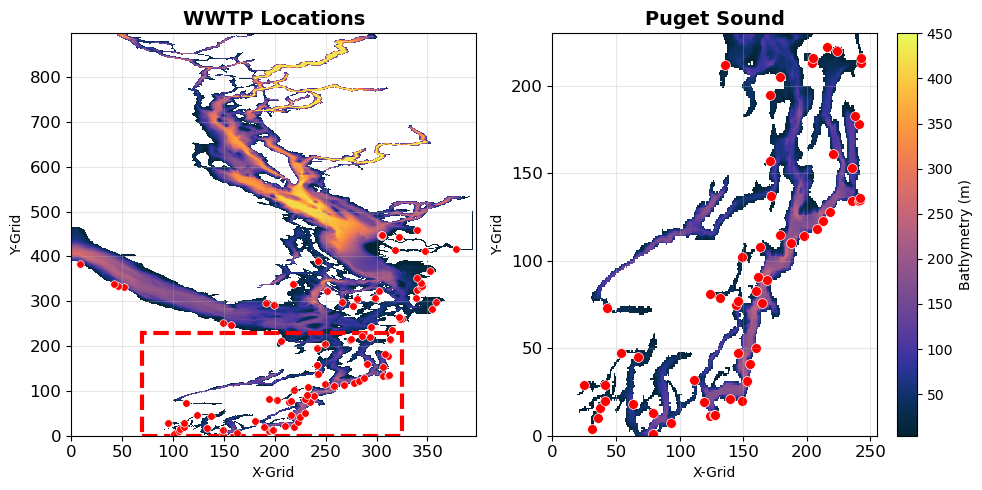

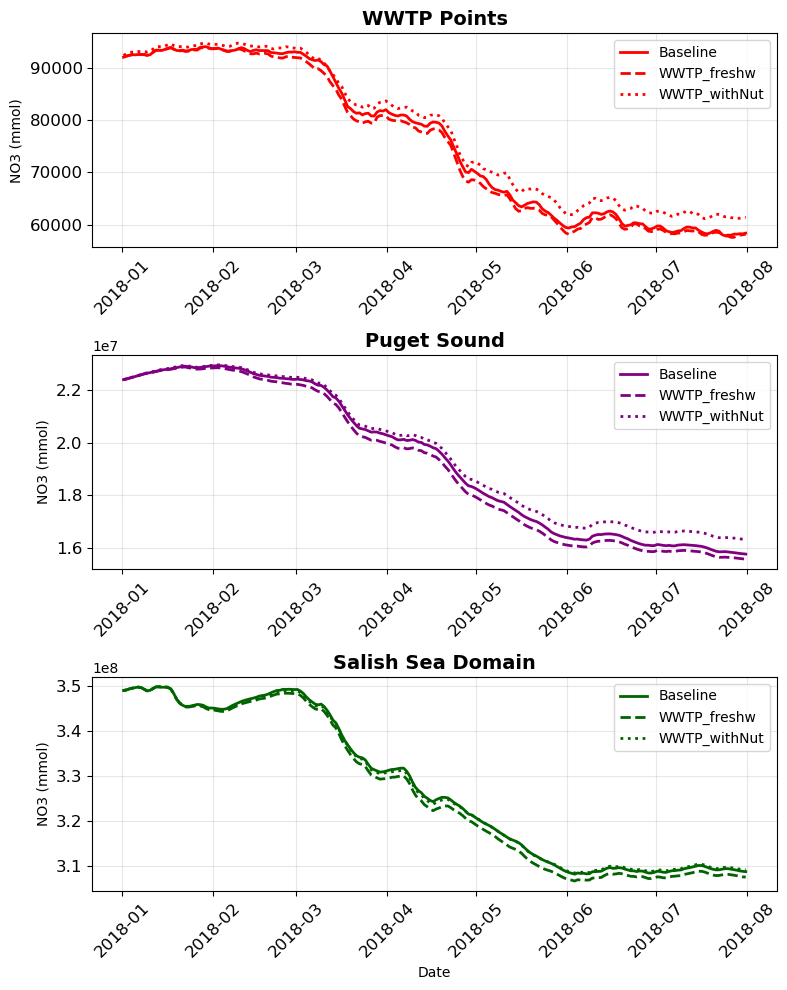

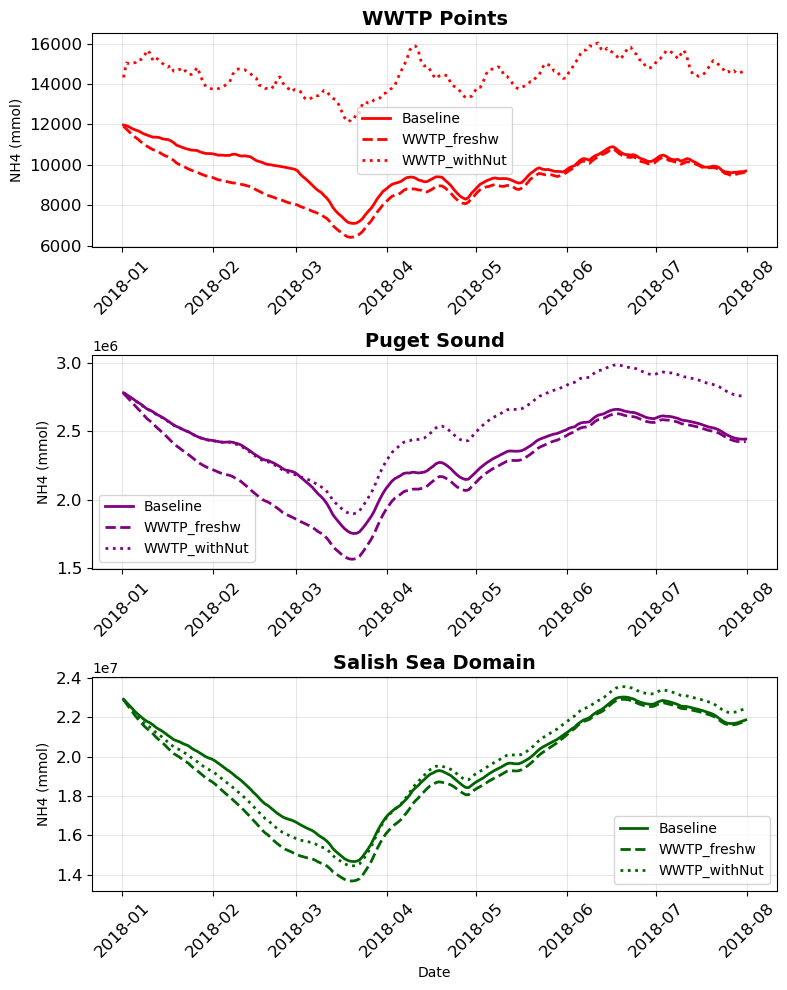

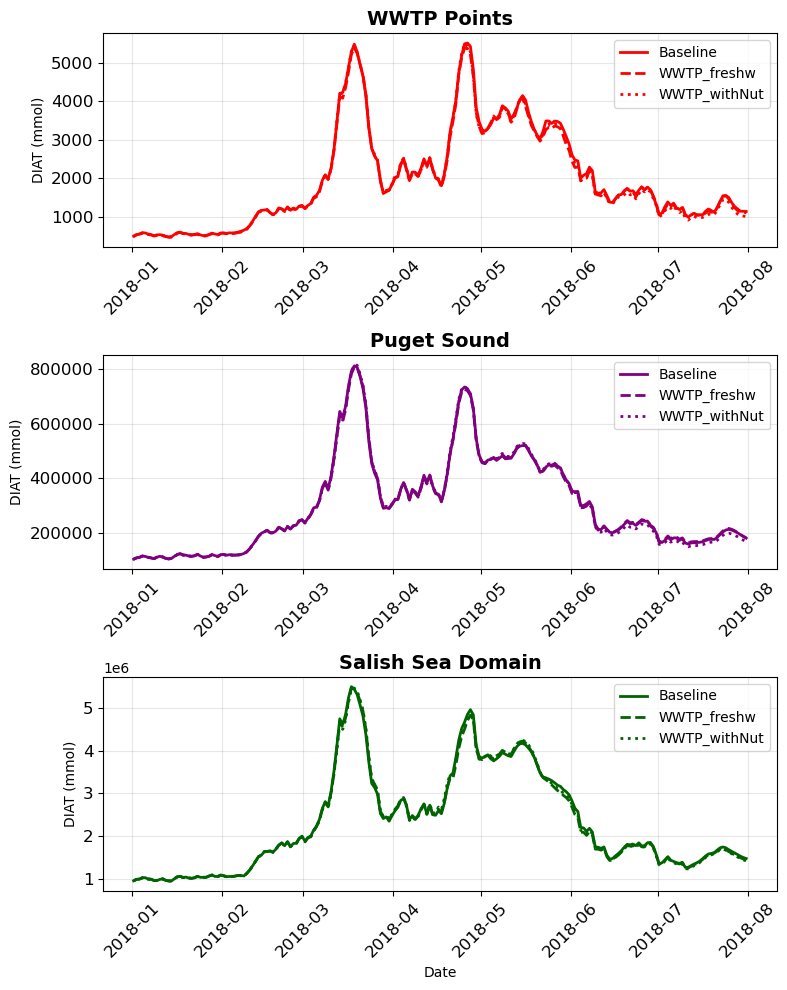

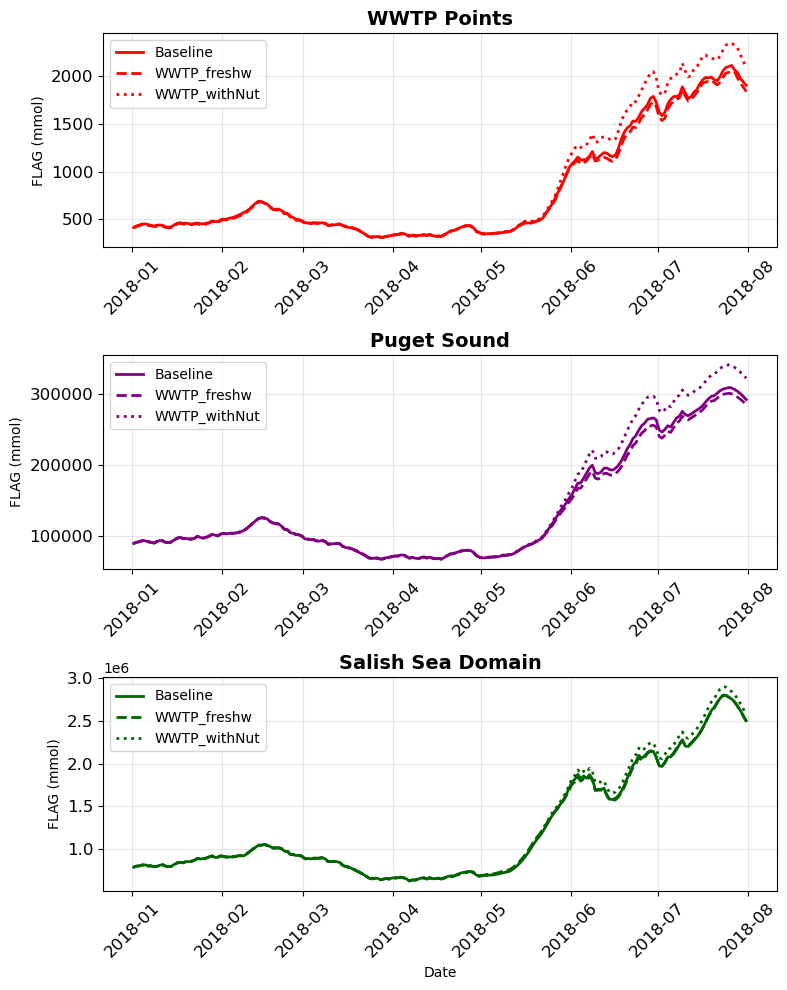

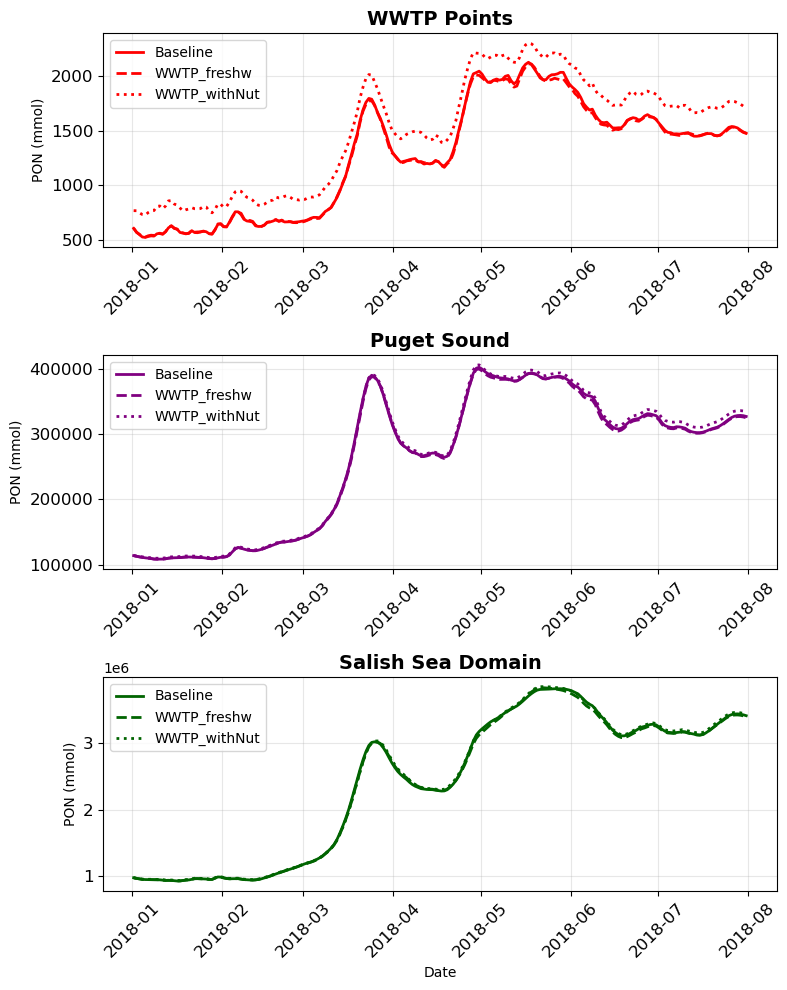

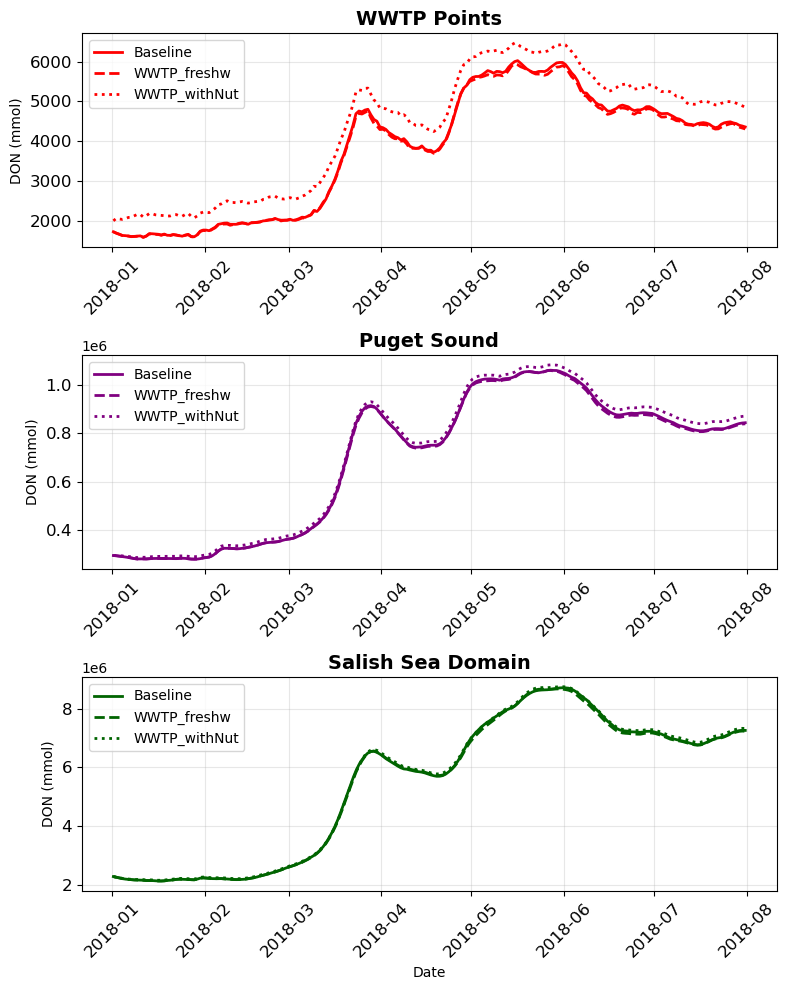

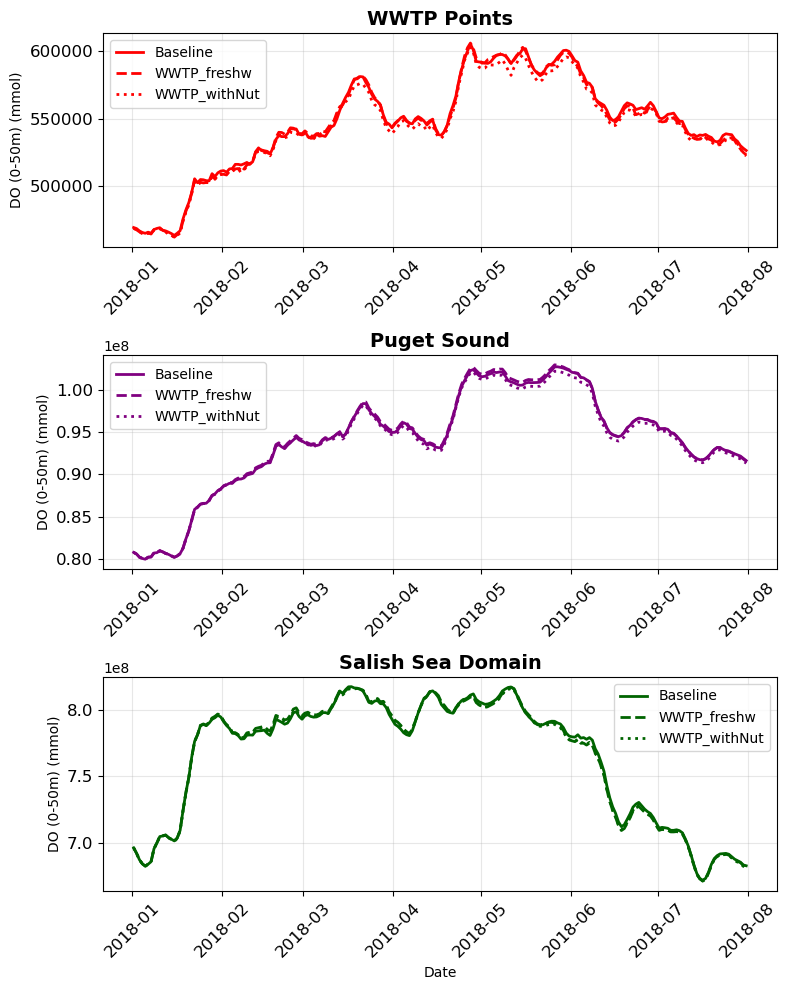

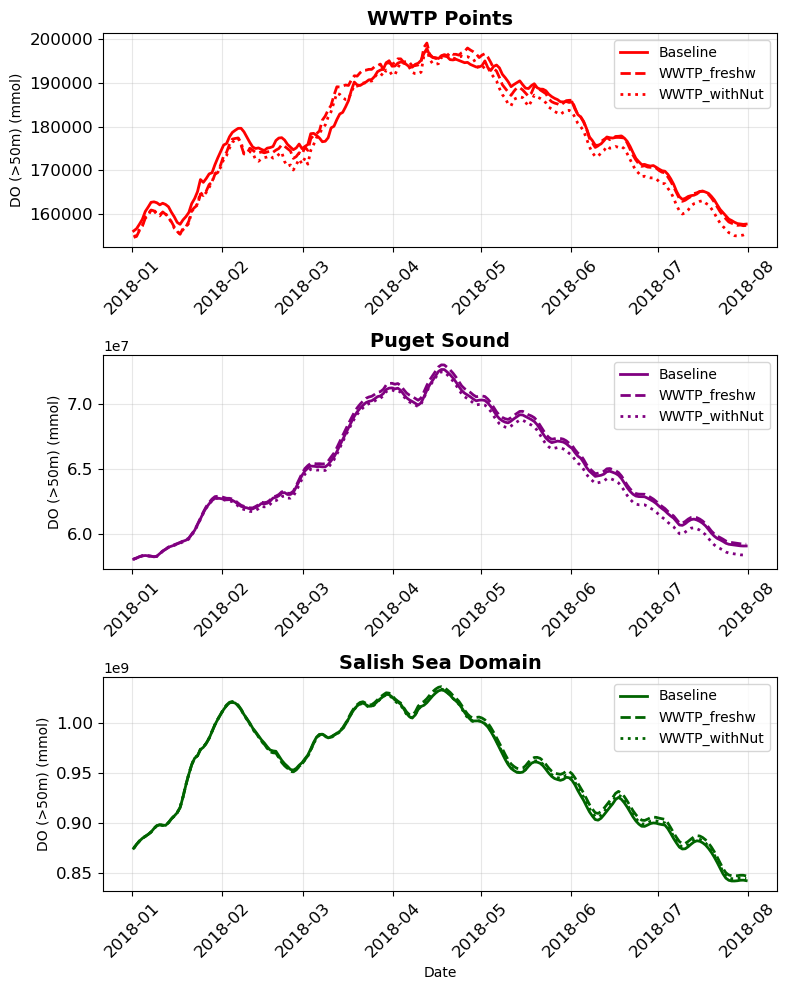

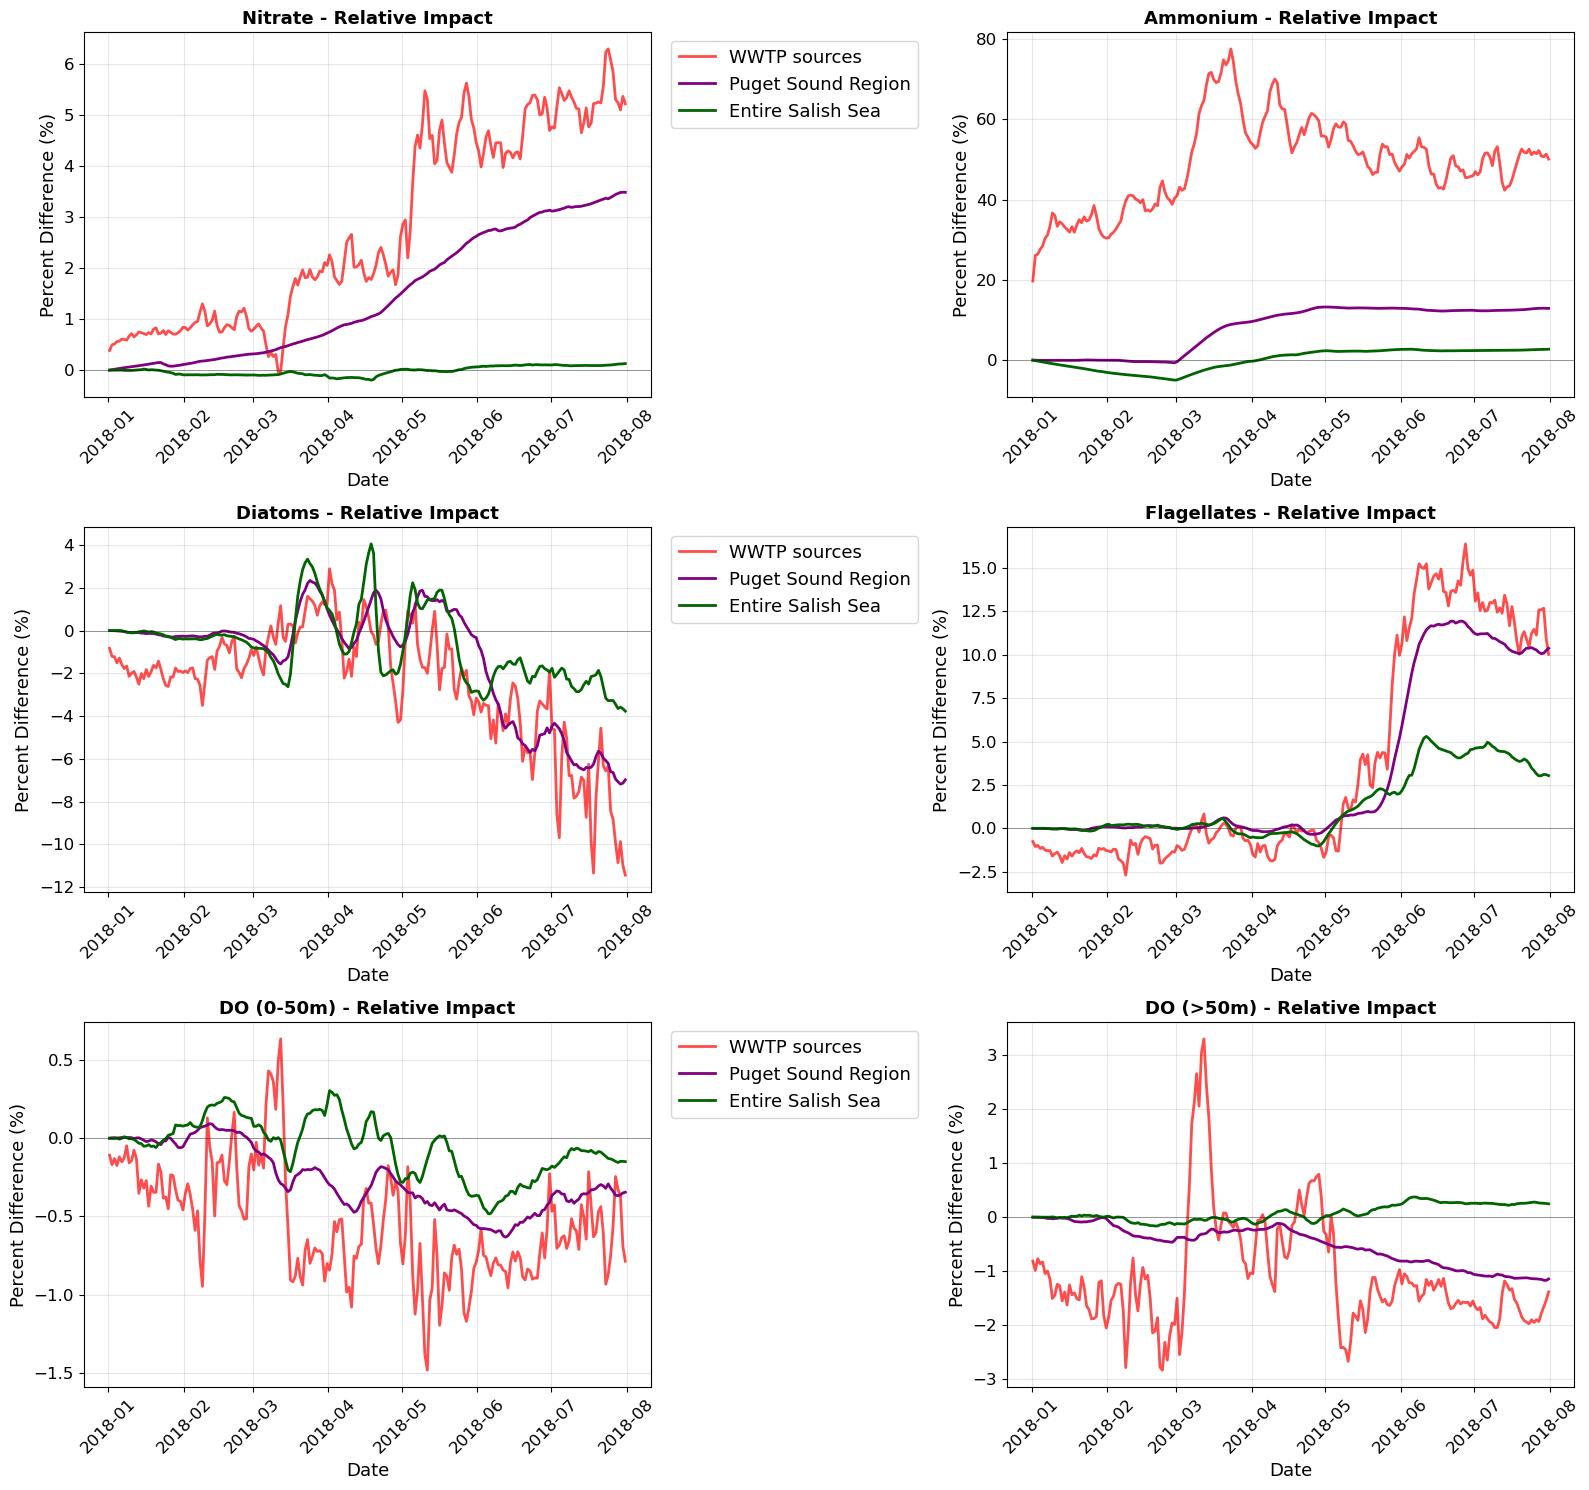

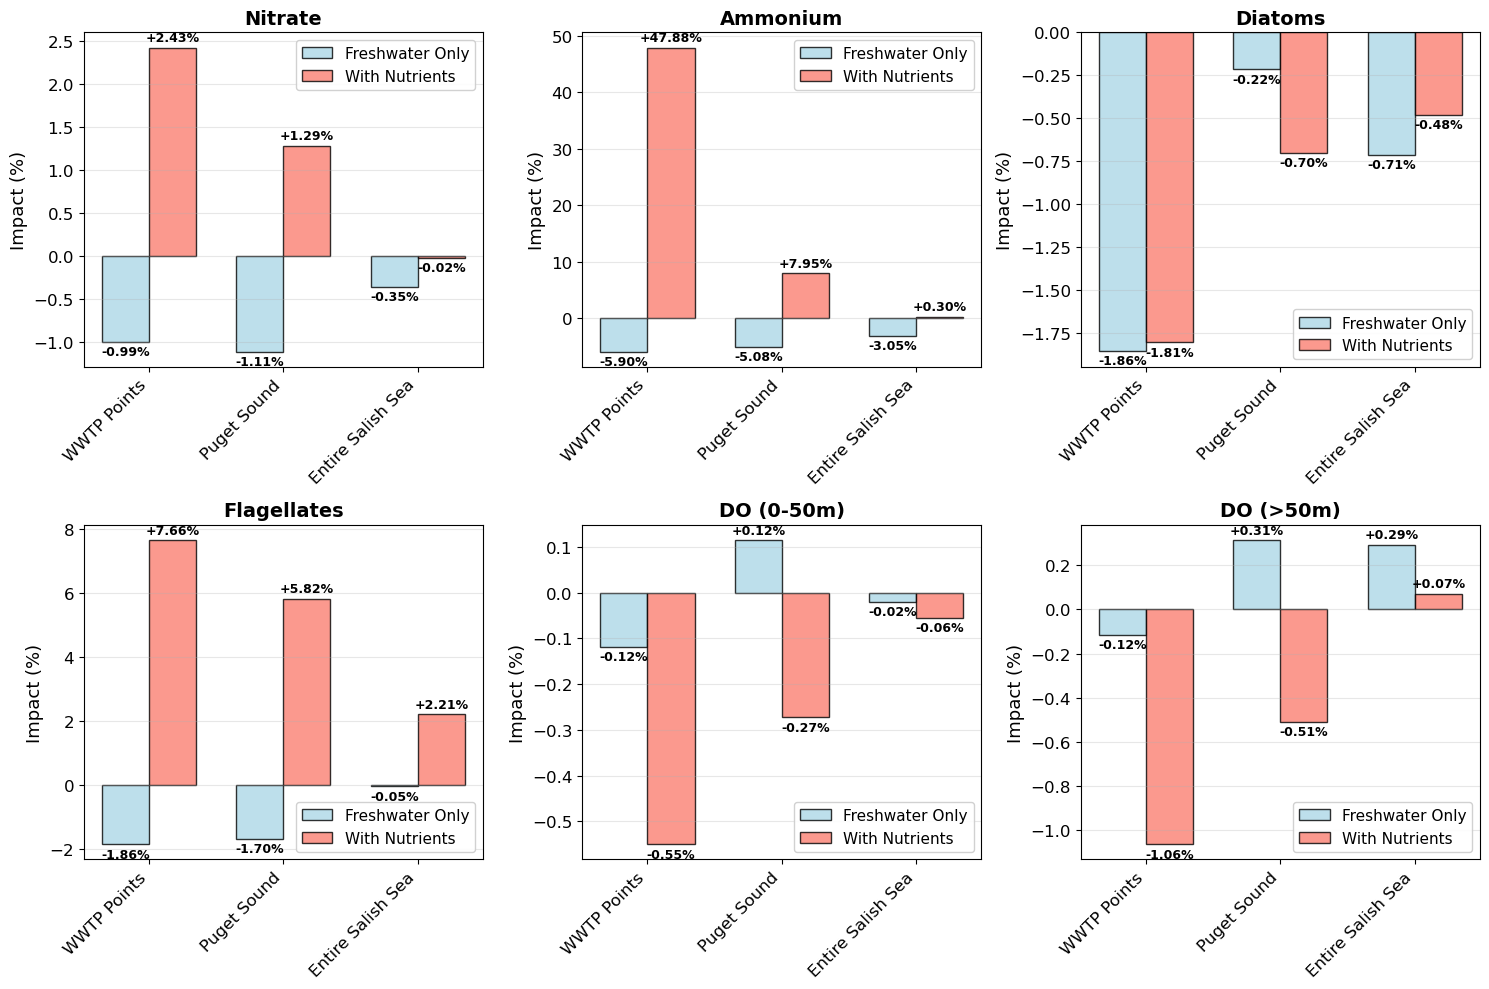

In [50]:
# Plot WWTP distribution
#plot_wwtp_discharge_depth_distribution()
plot_spatial()
    
# Create plots
plot_comparison(all_results, start_date, end_date)
    
# Plot relative impacts
plot_relative_impacts(all_results)
    
    # Plot scaled impacts summary
plot_scaled_impacts_summary(all_results)
    